In [14]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from numba import jit
import pandas as pd

In [15]:
RESULTS_PATH = "compare_SGD_and_FPA/"

In [16]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

In [17]:
GANTRY_CRANE_PARAMETERS = ut.load_json("best_parameters.json")

In [18]:
from model import Simulator

simulator_SGD = Simulator(DT, NUM_STEPS)
simulator_FPA = Simulator(DT, NUM_STEPS)

In [19]:
variations_json = ut.load_json("variations.json")
print(variations_json)
variation_names = []
for variation in variations_json:
    variation_names.append(variation)

random_variations = [variations_json[index] for index in variation_names]

{'Variasi ke-1': {'initial_condition': [0.2519, 0.4078, 0.0], 'setpoint': [0.6665, 0.5815]}, 'Variasi ke-2': {'initial_condition': [0.6874, 0.5781, 0.0], 'setpoint': [0.2105, 0.4397]}, 'Variasi ke-3': {'initial_condition': [0.9335, 0.4954, 0.0], 'setpoint': [0.261, 0.5535]}, 'Variasi ke-4': {'initial_condition': [0.4587, 0.4064, 0.0], 'setpoint': [1.1531, 0.507]}, 'Variasi ke-5': {'initial_condition': [1.2418, 0.4539, 0.0], 'setpoint': [0.1026, 0.5178]}, 'Variasi ke-6': {'initial_condition': [0.7257, 0.4327, 0.0], 'setpoint': [0.1669, 0.498]}, 'Variasi ke-7': {'initial_condition': [0.3219, 0.4218, 0.0], 'setpoint': [0.6137, 0.5875]}, 'Variasi ke-8': {'initial_condition': [1.2233, 0.4174, 0.0], 'setpoint': [0.3331, 0.5943]}, 'Variasi ke-9': {'initial_condition': [0.8584, 0.5288, 0.0], 'setpoint': [0.1827, 0.4483]}, 'Variasi ke-10': {'initial_condition': [0.4882, 0.4967, 0.0], 'setpoint': [0.9791, 0.5934]}}


In [20]:
@jit(nopython=True)
def get_rise_index(time_series, setpoint):
    time_series = np.array(time_series)

    if time_series[0] > setpoint:
        time_series = -time_series
        setpoint = -setpoint

    # Cari nilai awal dari time series
    start_value = time_series[0]
    # Hitung 10% dan 90% dari nilai maksimum
    threshold_10 = start_value + 0.1 * np.abs(setpoint - start_value)
    threshold_90 = start_value + 0.9 * np.abs(setpoint - start_value)

    # Cari index ketika time series memiliki nilai terdekat dengan 10% dan 90% threshold
    rise_10_index = len(time_series) - 1
    for i in range(len(time_series)):
        if time_series[i] > threshold_10:
            rise_10_index = i
            break

    rise_90_index = len(time_series) - 1
    for i in range(len(time_series)):
        if time_series[i] > threshold_90:
            rise_90_index = i
            break

    return rise_10_index, rise_90_index

In [21]:
@jit(nopython=True)
def get_settling_index(time_series, setpoint, threshold=0.02):
    time_series = np.array(time_series)

    # Toleransi terhadap steady state
    bound = np.abs(setpoint - time_series[0]) * np.abs(threshold)
    if setpoint == 0:
        bound = threshold
          
    lower_bound = setpoint - bound
    upper_bound = setpoint + bound
        
    # Cari waktu ketika time series pertama kali melewati threshold 2%
    settling_index = len(time_series) - 1   # Nilai default jika tidak ditemukan
    for i in range(len(time_series) - 1, 0, -1):
        if time_series[i] < lower_bound or time_series[i] > upper_bound:
            settling_index = i
            break

    return settling_index

In [22]:
@jit(nopython=True)
def get_overshoot_index(time_series, setpoint):
    time_series = np.array(time_series)

    if time_series[0] > setpoint:
        time_series = -time_series
        setpoint = -setpoint

    # Cari index ketika time series pertama kali melewati setpoint
    pass_index = len(time_series)   # Nilai default jika tidak ditemukan
    for i in range(len(time_series)):
        if time_series[i] > setpoint:
            pass_index = i
            break

    # Jika time series tidak pernah melewati setpoint
    if pass_index == len(time_series):
        return pass_index
    
    # Cari index ketika time series mencapai nilai maksimum
    overshoot_index = np.argmax(time_series[pass_index:]) + pass_index

    return overshoot_index

In [23]:
@jit(nopython=True)
def get_RMSE_settle(settled_time_series, setpoint):
    time_series = np.array(settled_time_series)

    # Hitung RMSE terhadap setpoint
    RMSE = np.sqrt(np.mean((time_series - setpoint)**2))
    
    return RMSE

In [24]:
def get_quality_metrics(simulation_result, setpoints):
    time = [simulation_result["time"][i] for i in range(NUM_STEPS)]
    trolley_position = [simulation_result["trolley_position"][i] for i in range(NUM_STEPS)]
    cable_length = [simulation_result["cable_length"][i] for i in range(NUM_STEPS)]
    sway_angle = [simulation_result["sway_angle"][i] for i in range(NUM_STEPS)]

    # Calculate rise time, settling time, overshoot, and RMSE for x
    rise_10_index_x, rise_90_index_x = get_rise_index(trolley_position, setpoints["x"])
    rise_time_x = time[rise_90_index_x] - time[rise_10_index_x]
    settling_index_x = get_settling_index(trolley_position, setpoints["x"])
    settling_time_x = time[settling_index_x] - time[0]
    overshoot_index_x = get_overshoot_index(trolley_position, setpoints["x"])
    overshoot_x = trolley_position[overshoot_index_x] - setpoints["x"] if overshoot_index_x < NUM_STEPS else 0
    RMSE_x = get_RMSE_settle(trolley_position[settling_index_x:], setpoints["x"])

    # Calculate rise time, settling time, overshoot, and RMSE for l
    rise_10_index_l, rise_90_index_l = get_rise_index(cable_length, setpoints["l"])
    rise_time_l = time[rise_90_index_l] - time[rise_10_index_l]
    settling_index_l = get_settling_index(cable_length, setpoints["l"])
    settling_time_l = time[settling_index_l] - time[0]
    overshoot_index_l = get_overshoot_index(cable_length, setpoints["l"])
    overshoot_l = cable_length[overshoot_index_l] - setpoints["l"]  if overshoot_index_l < NUM_STEPS else 0
    RMSE_l = get_RMSE_settle(cable_length[settling_index_l:], setpoints["l"])

    # Calculate settling time and RMSE for theta
    settling_index_theta = get_settling_index(sway_angle, 0, threshold=0.01) # threshold = 0.01 rad = 0.57 deg
    settling_time_theta = time[settling_index_theta] - time[0]
    RMSE_theta = get_RMSE_settle(sway_angle[settling_index_theta:], 0)
    max_amplitude_theta = np.max(np.abs(sway_angle))

    return {
        "rise_time_x": rise_time_x,
        "settling_time_x": settling_time_x,
        "overshoot_x": overshoot_x,
        "RMSE_x": RMSE_x,
        "rise_time_l": rise_time_l,
        "settling_time_l": settling_time_l,
        "overshoot_l": overshoot_l,
        "RMSE_l": RMSE_l,
        "settling_time_theta": settling_time_theta,
        "RMSE_theta": np.rad2deg(RMSE_theta),
        "max_amplitude_theta": np.rad2deg(max_amplitude_theta)
    }


In [25]:
metrics = ['rise_time_x', 'settling_time_x', 'overshoot_x', 'RMSE_x', 'rise_time_l', 'settling_time_l', 'overshoot_l', 'RMSE_l', 'settling_time_theta', 'RMSE_theta', 'max_amplitude_theta']


Initial condition:  {'x': 0.2519, 'l': 0.4078, 'theta': 0.0}
Setpoint:  {'x': 0.6665, 'l': 0.5815}


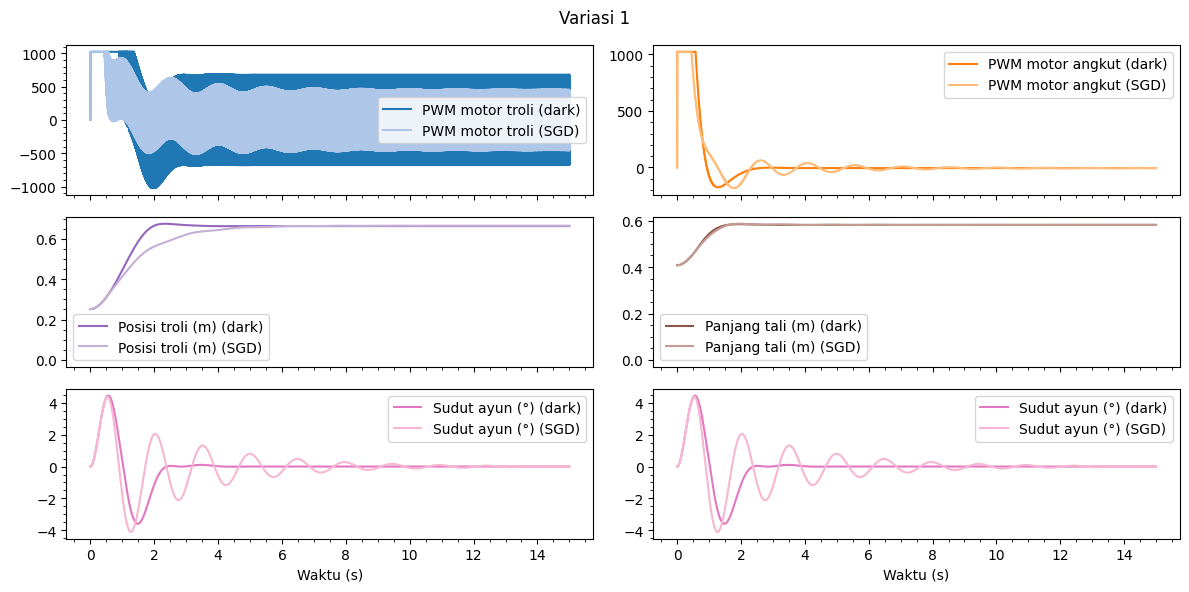

Initial condition:  {'x': 0.6874, 'l': 0.5781, 'theta': 0.0}
Setpoint:  {'x': 0.2105, 'l': 0.4397}


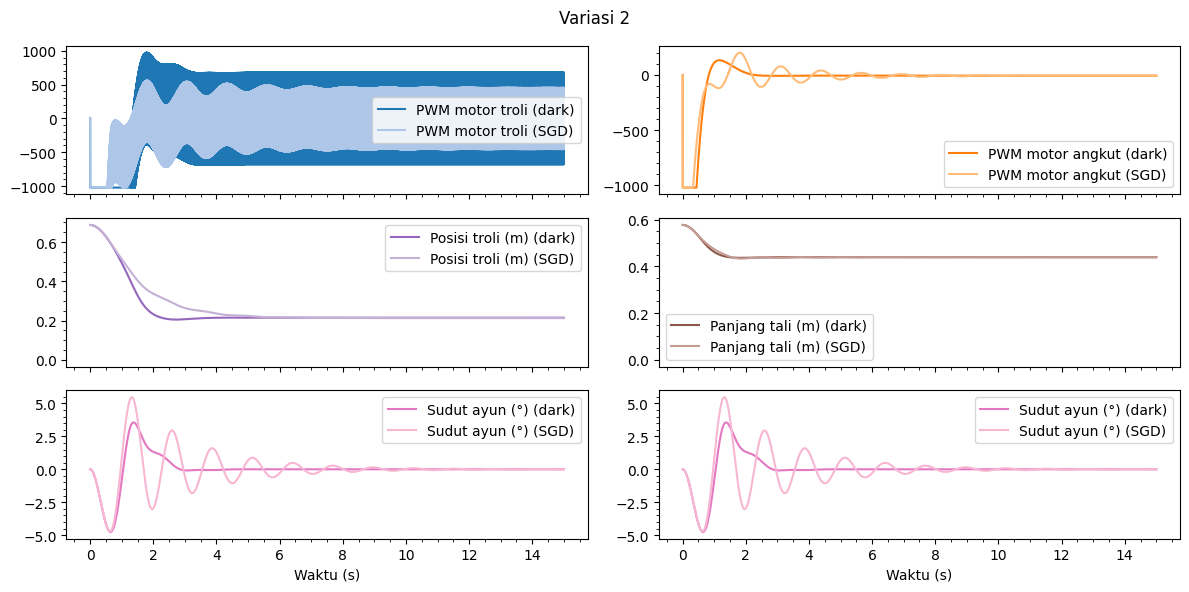

Initial condition:  {'x': 0.9335, 'l': 0.4954, 'theta': 0.0}
Setpoint:  {'x': 0.261, 'l': 0.5535}


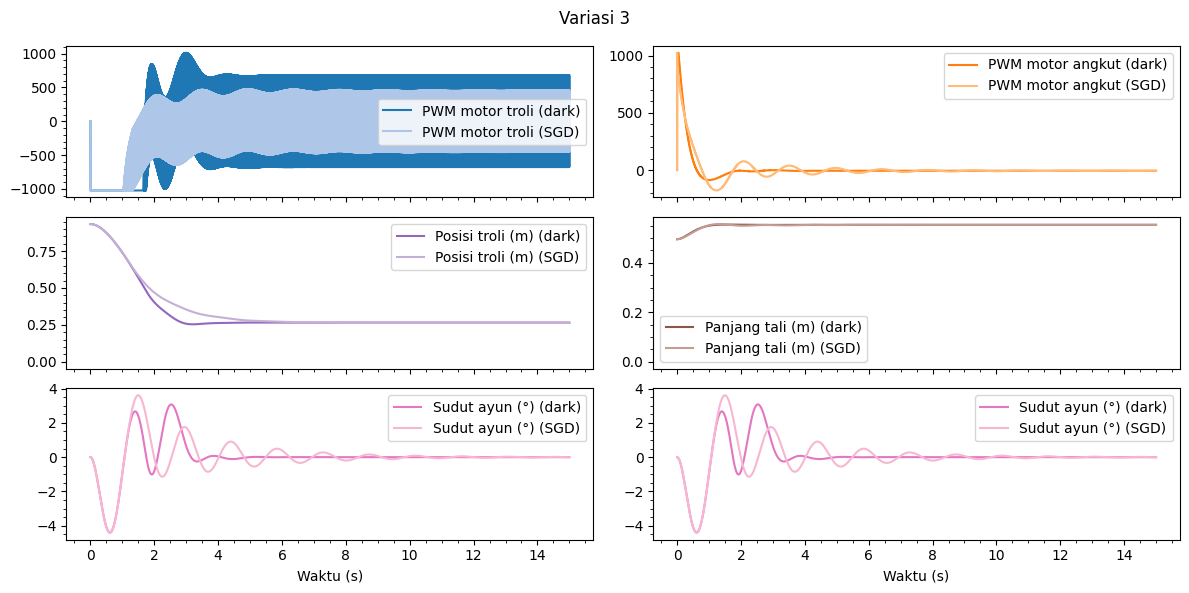

Initial condition:  {'x': 0.4587, 'l': 0.4064, 'theta': 0.0}
Setpoint:  {'x': 1.1531, 'l': 0.507}


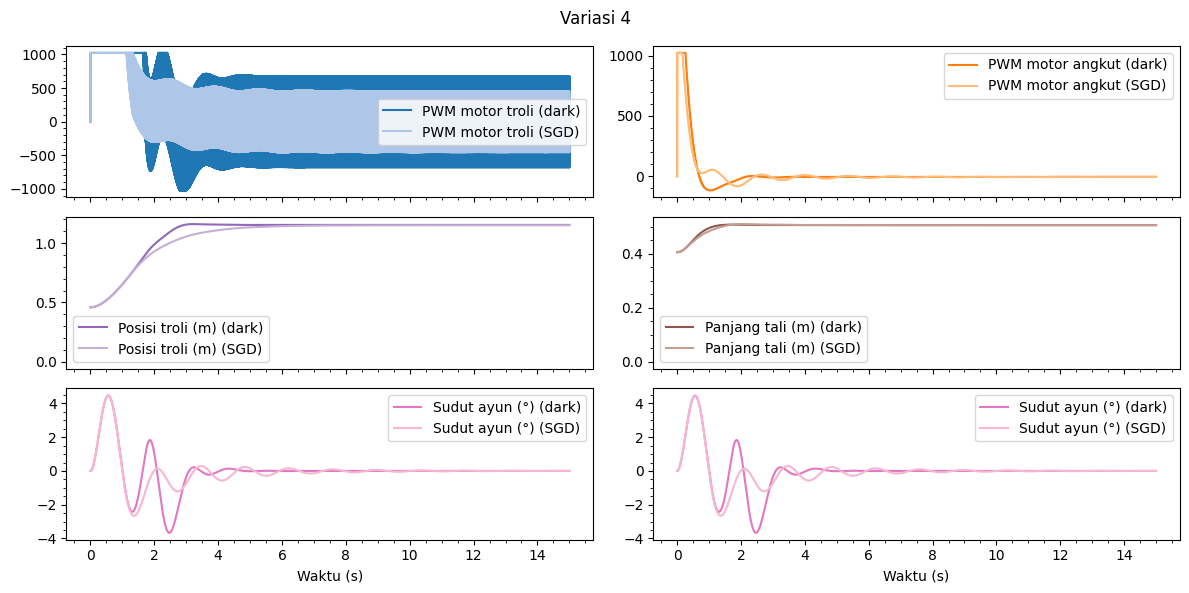

Initial condition:  {'x': 1.2418, 'l': 0.4539, 'theta': 0.0}
Setpoint:  {'x': 0.1026, 'l': 0.5178}


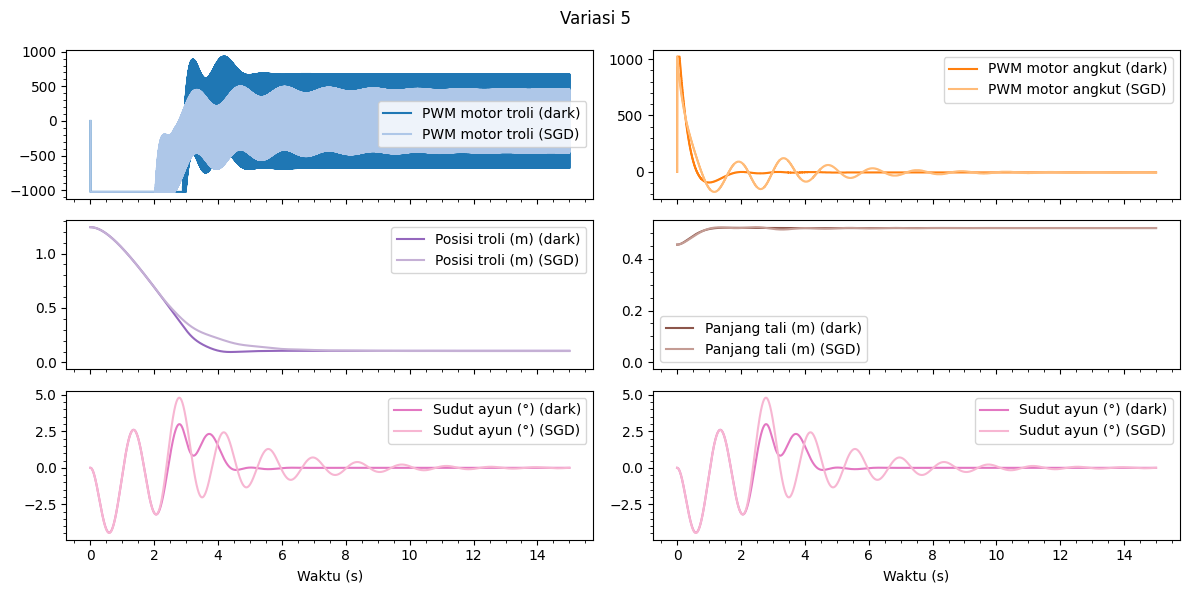

Initial condition:  {'x': 0.7257, 'l': 0.4327, 'theta': 0.0}
Setpoint:  {'x': 0.1669, 'l': 0.498}


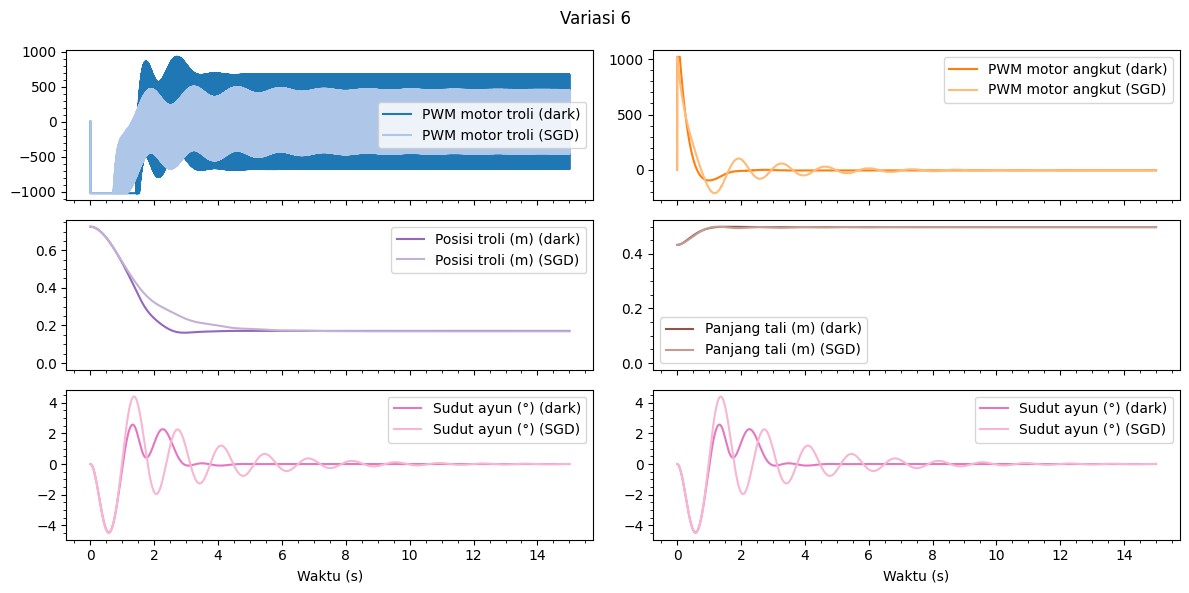

Initial condition:  {'x': 0.3219, 'l': 0.4218, 'theta': 0.0}
Setpoint:  {'x': 0.6137, 'l': 0.5875}


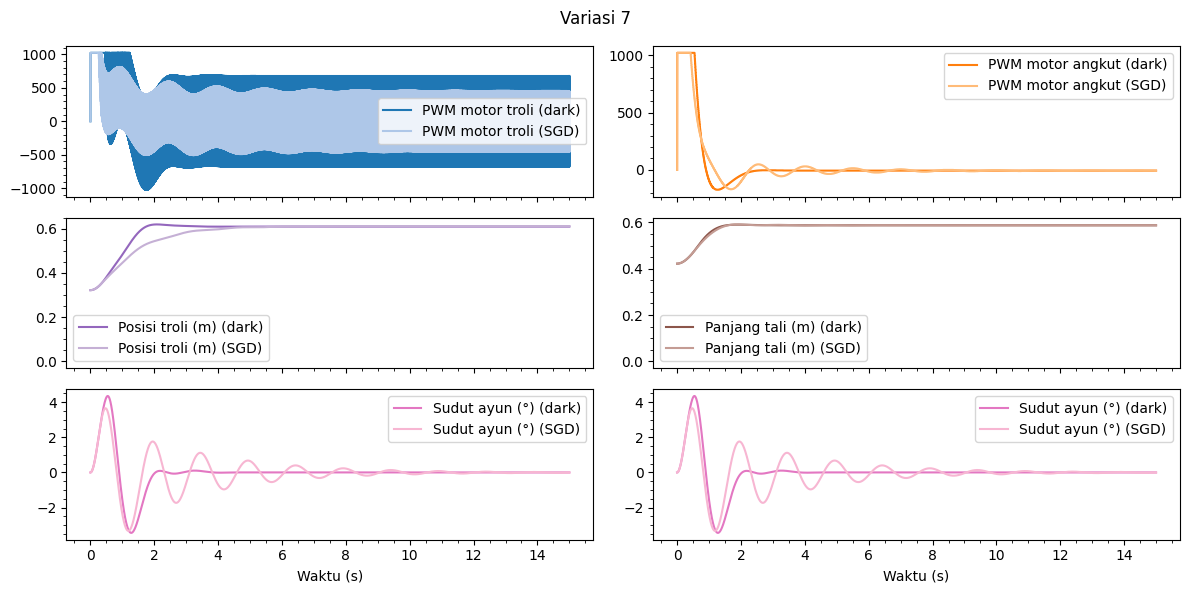

Initial condition:  {'x': 1.2233, 'l': 0.4174, 'theta': 0.0}
Setpoint:  {'x': 0.3331, 'l': 0.5943}


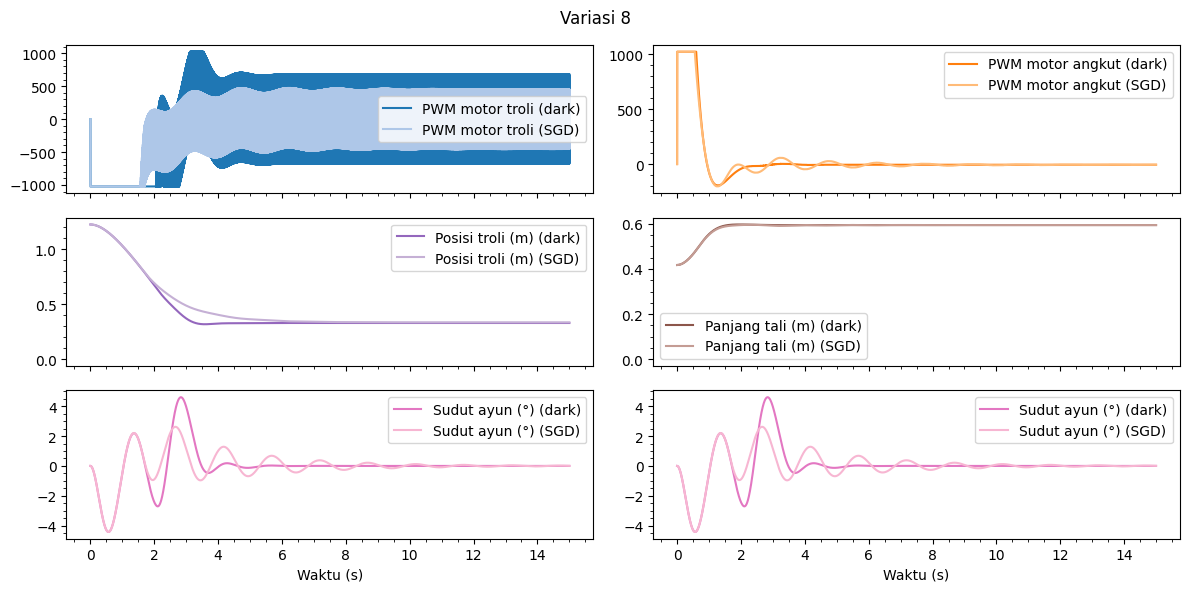

Initial condition:  {'x': 0.8584, 'l': 0.5288, 'theta': 0.0}
Setpoint:  {'x': 0.1827, 'l': 0.4483}


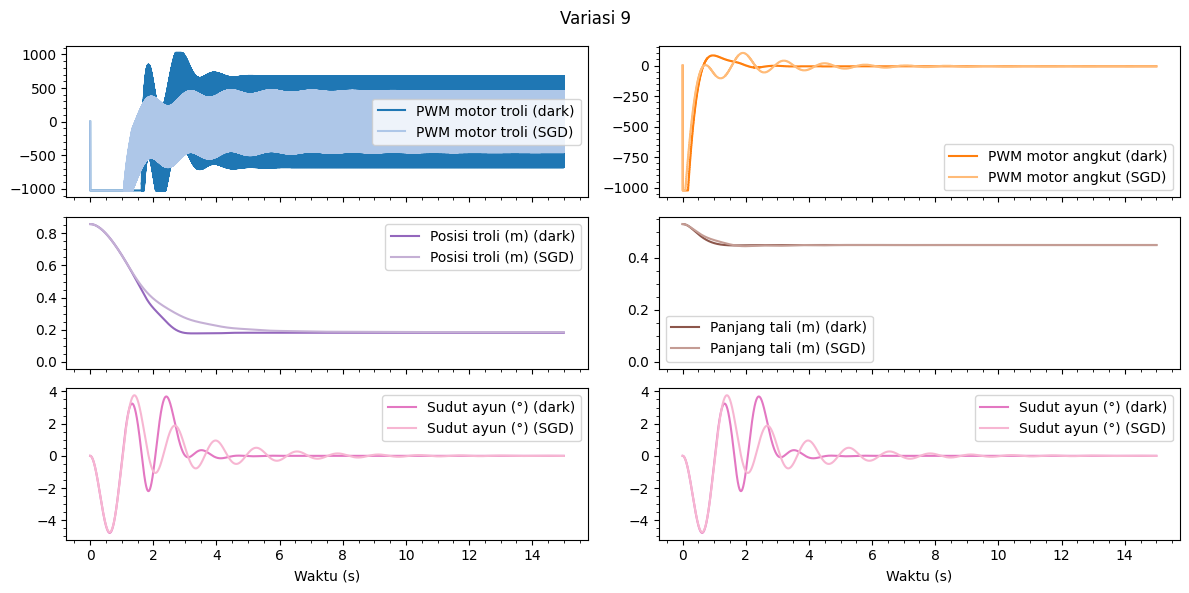

Initial condition:  {'x': 0.4882, 'l': 0.4967, 'theta': 0.0}
Setpoint:  {'x': 0.9791, 'l': 0.5934}


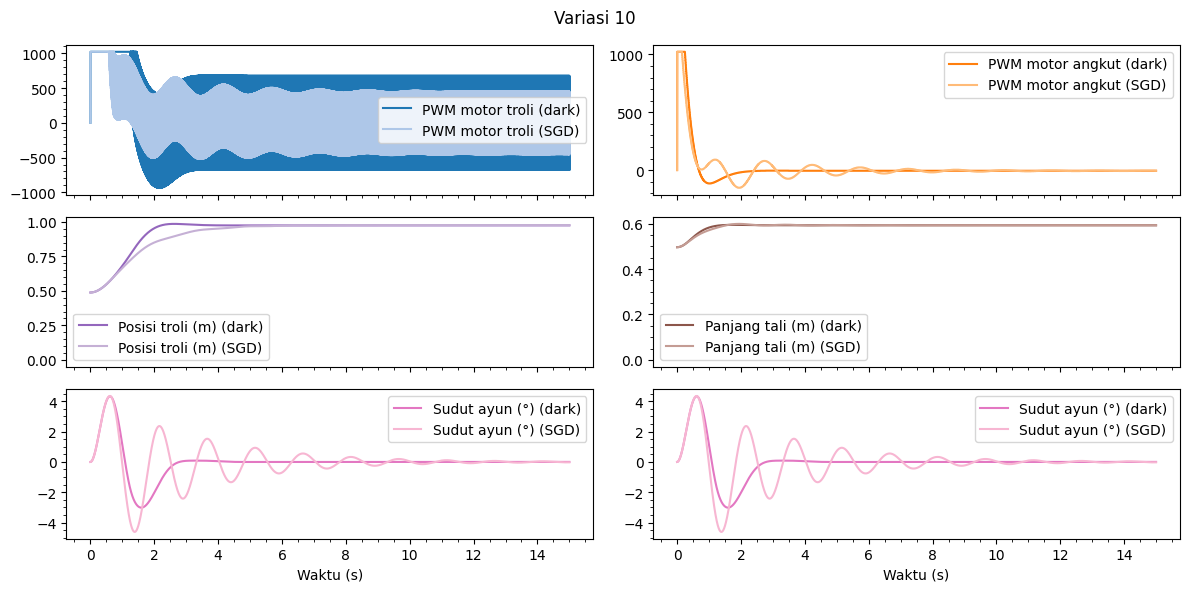

In [26]:
# Load the best parameters
SGD_SMC_best_parameters = ut.load_json(RESULTS_PATH + "SGD_SMC_best_parameters.json")
FPA_SMC_best_parameters = ut.load_json(RESULTS_PATH + "FPA_SMC_best_parameters.json")


# Simulate the gantry crane system using the best parameters
for index, variation in enumerate(random_variations):
    initial_conditions = {
            "x": variation["initial_condition"][0],
            "l": variation["initial_condition"][1],
            "theta": variation["initial_condition"][2],
        }

    setpoints = {
        "x": variation["setpoint"][0],
        "l": variation["setpoint"][1],
    }

    print("Initial condition: ", initial_conditions)
    print("Setpoint: ", setpoints)
    simulator_SGD.simulate_with_SMC(
        GANTRY_CRANE_PARAMETERS,
        SGD_SMC_best_parameters,
        setpoints=setpoints,
        initial_conditions=initial_conditions,
    )
    SGD_simulation_result = simulator_SGD.get_results()

    SGD_quality_metrics = get_quality_metrics(SGD_simulation_result, setpoints)

    simulator_FPA.simulate_with_SMC(
        GANTRY_CRANE_PARAMETERS,
        FPA_SMC_best_parameters,
        setpoints=setpoints,
        initial_conditions=initial_conditions,
    )
    FPA_simulation_result = simulator_FPA.get_results()

    FPA_quality_metrics = get_quality_metrics(FPA_simulation_result, setpoints)

    variation = {
        'Metrik': metrics,
        'SGD': list(SGD_quality_metrics.values()),
        'FPA': list(FPA_quality_metrics.values())
    }

    df = pd.DataFrame(variation)

    with pd.ExcelWriter(RESULTS_PATH + f"metrics.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=f'Variasi {index+1}', index=False)

    # Create a figure and a set of subplots
    figure, ax = plt.subplots(3, 2, figsize=(12, 6), sharex=True)
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(f"Variasi {index+1}", fontsize=12)
    ut.add_to_subplot(ax[0, 0], FPA_simulation_result["time"], FPA_simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (dark)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], FPA_simulation_result["time"], FPA_simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (dark)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], FPA_simulation_result["time"], FPA_simulation_result["trolley_position"], ylabel="Posisi troli (m) (dark)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[1, 1], FPA_simulation_result["time"], FPA_simulation_result["cable_length"], ylabel="Panjang tali (m) (dark)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[2, 0], FPA_simulation_result["time"], np.rad2deg(FPA_simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (dark)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[2, 1], FPA_simulation_result["time"], np.rad2deg(FPA_simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (dark)", color=plt.get_cmap("tab20")(12))

    ut.add_to_subplot(ax[0, 0], SGD_simulation_result["time"], SGD_simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (SGD)", color=plt.get_cmap("tab20")(1))
    ut.add_to_subplot(ax[0, 1], SGD_simulation_result["time"], SGD_simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (SGD)", color=plt.get_cmap("tab20")(3))
    ut.add_to_subplot(ax[1, 0], SGD_simulation_result["time"], SGD_simulation_result["trolley_position"], ylabel="Posisi troli (m) (SGD)", color=plt.get_cmap("tab20")(9))
    ut.add_to_subplot(ax[1, 1], SGD_simulation_result["time"], SGD_simulation_result["cable_length"], ylabel="Panjang tali (m) (SGD)", color=plt.get_cmap("tab20")(11))
    ut.add_to_subplot(ax[2, 0], SGD_simulation_result["time"], np.rad2deg(SGD_simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (SGD)", color=plt.get_cmap("tab20")(13))
    ut.add_to_subplot(ax[2, 1], SGD_simulation_result["time"], np.rad2deg(SGD_simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (SGD)", color=plt.get_cmap("tab20")(13))

    plt.tight_layout()

    # Save the figure as SVG
    plt.savefig(RESULTS_PATH + f"figure/variation_{index+1}.svg")
    plt.show()